In [2]:
#importamos las librerias que vamos a emplear
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers  import Conv2D, Conv2DTranspose
from tensorflow.keras.layers  import MaxPool2D, GlobalMaxPool2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.layers  import Concatenate, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
import cv2
import os
import nibabel as nib
import dicom2nifti
from PIL import Image
from nilearn.image import resample_img
import pylab as plt

/home/martin/anaconda3/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
def load_images_from_folder(folder): #funcion para cargar de forma ordenada las imagenes 
    images = []
    path = []
    
    for filename in os.listdir(folder):
        path.append(filename)
    path_sorted = sorted(path)
    
    for file in path_sorted:
        data = nib.nifti1.load(os.path.join(folder,file))
        img = data.get_fdata()
        img2 = img/img.max()
        if img2 is not None:
            images.append(img2)
    
    return images

def load_mask_from_folder(folder): #funcion para cargas de forma ordenada las mascaras 
    images = []
    path = []
    
    for filename in os.listdir(folder):
        path.append(filename)
    path_sorted = sorted(path)
    
    for file in path_sorted:
        data = nib.nifti1.load(os.path.join(folder,file))
        img = data.get_fdata()
        if img is not None:
            images.append(img)
    
    return images

def made_three_channel_image(images): #funcion para concatenar tres imagenes en un
    images_final = []
    for i in range(0,len(images),3):
        images_add = np.stack((images[i],images[i+1],images[i+2]),axis = -1)
        images_final.append(images_add)
    return images_final

def slice_3d_image(images): #funcion para convertir volumenes 3d en imagenes 2d de los cortes axiales
    slices = []
    for element in images:
        for i in range(element.shape[2]):
            slices.append(element[:,:,i])
    return slices

def create_3d_image(images): #funcion para convertir cortes axiales 2d en un volumen 3d
    contador = 0
    paciente = []
    images_3d = []
    for i in range(0,len(images),62):
        for j in range(i,i+62,1):
            paciente.append(images[j])
        images_3d.append(np.array(paciente))
        paciente = []
    images_3d = np.array(images_3d)
    final_image = np.moveaxis(images_3d,1,-1)
    return(final_image)


def plot_sample(X, y, preds, ix=None): #funcion para mostrar figuras
    plt.imshow(X[ix].squeeze(),cmap='gray')
    plt.xticks([]), plt.yticks([])  
    plt.xlabel('Head image')
    plt.show()
    
    plt.imshow(y[ix], cmap='gray')
    plt.xticks([]), plt.yticks([])  
    plt.xlabel('Original mask')
    plt.show()
    
    plt.imshow(preds[ix], cmap='gray')
    plt.xticks([]), plt.yticks([])  
    plt.xlabel('Mask prediction')
    plt.show()

In [163]:
#hacemos una lista con las máscaras
path = []
for filename in os.listdir('/home/martin/Escritorio/red_neuronal_2/data/mask'):
    path.append(filename)
path_sorted = sorted(path)

In [40]:
#hacemos una lista con los directorios donde queremos guardar las salidas
paths = []
for folder in os.listdir('/home/martin/Escritorio/PACIENTES_2'):
    folder2 = os.path.join('/home/martin/Escritorio/PACIENTES_2', folder)
    paths.append(folder2)
paths_sorted = sorted(paths)

In [4]:
#cargamos las imagenes y las macaras que entrenaran la red

inputs = np.array(slice_3d_image(made_three_channel_image(load_images_from_folder('/home/martin/Escritorio/red_neuronal_2/data/images'))))
targets = np.array(tf.keras.utils.to_categorical(slice_3d_image(load_mask_from_folder('/home/martin/Escritorio/red_neuronal_2/data/mask'))))


Definimos la U-Net
![texto alternativo](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
#definimos nuestra u-net
hn = 'he_normal'
def unet(input_tensor, pretrained_weights=None):
    '''downsample'''
    conv1 = Conv2D(8, 3, padding='same', kernel_initializer = hn)(input_tensor)
    batc1 = BatchNormalization(axis=-1)(conv1)
    acti1 = Activation('relu')(batc1)
    conv2 = Conv2D(16, 3, padding='same', kernel_initializer = hn)(acti1)
    batc2 = BatchNormalization(axis=-1)(conv2)
    acti2 = Activation('relu')(batc2)
    maxp1 = MaxPool2D(2)(acti2)


    conv3 = Conv2D(16, 3, padding='same', kernel_initializer = hn)(maxp1)
    batc3 = BatchNormalization(axis=-1)(conv3)
    acti3 = Activation('relu')(batc3)
    conv4 = Conv2D(32, 3, padding='same', kernel_initializer = hn)(acti3)
    batc4 = BatchNormalization(axis=-1)(conv4)
    acti4 = Activation('relu')(batc4)
    maxp2 = MaxPool2D(2)(acti4)


    conv5 = Conv2D(32, 3, padding='same', kernel_initializer = hn)(maxp2)
    batc5 = BatchNormalization(axis=-1)(conv5)
    acti5 = Activation('relu')(batc5)
    conv6 = Conv2D(64, 3, padding='same', kernel_initializer = hn)(acti5)
    batc6 = BatchNormalization(axis=-1)(conv6)
    acti6 = Activation('relu')(batc6)
    maxp3 = MaxPool2D(2)(acti6)

    conv7 = Conv2D(64, 3, padding='same', kernel_initializer = hn)(maxp3)
    batc7 = BatchNormalization(axis=-1)(conv7)
    acti7 = Activation('relu')(batc7)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer = hn)(acti7)
    batc8 = BatchNormalization(axis=-1)(conv8)
    acti8 = Activation('relu')(batc8)


    '''upsample'''
    upsa1 = UpSampling2D(2)(acti8)
    merg1 = Concatenate(axis=-1)([conv6, upsa1])
    conv9 = Conv2DTranspose(64, 3, padding='same', kernel_initializer = hn)(merg1)
    batc9 = BatchNormalization(axis=-1)(conv9)
    acti9 = Activation('relu')(batc9)
    conv10 = Conv2DTranspose(64, 3, padding='same', kernel_initializer = hn)(acti9)
    batc10 = BatchNormalization(axis=-1)(conv10)
    acti10 = Activation('relu')(batc10)

    upsa2 = UpSampling2D(2)(acti10)
    merg2 = Concatenate(axis=-1)([conv4, upsa2])
    conv11 = Conv2DTranspose(32, 3, padding='same', kernel_initializer = hn)(merg2)
    batc11 = BatchNormalization(axis=-1)(conv11)
    acti11 = Activation('relu')(batc11)
    conv12 = Conv2DTranspose(32, 3, padding='same', kernel_initializer = hn)(acti11)
    batc12 = BatchNormalization(axis=-1)(conv12)
    acti12 = Activation('relu')(batc12)

    upsa3 = UpSampling2D(2)(acti12)
    merg3 = Concatenate(axis=-1)([conv2, upsa3])
    conv13 = Conv2DTranspose(16, 3, padding='same', kernel_initializer = hn)(merg3)
    batc13 = BatchNormalization(axis=-1)(conv13)
    acti13 = Activation('relu')(batc13)
    conv14 = Conv2DTranspose(16, 3, padding='same', kernel_initializer = hn)(acti13)
    convol = Conv2D(7,1, activation='sigmoid')(conv14)


    model = Model(inputs=input_tensor, outputs=convol)
    return model


In [95]:
#compilamos la red para ver la evolucion de las capas
input_shape = Input((72,72,3))
model = unet(input_shape)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 72, 72, 8)    224         input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, 72, 72, 8)    32          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 72, 72, 8)    0           batch_normalization_273[0][0]    
______________________________________________________________________________________

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
18/18 [==============================] - 43s 2s/step - loss: 0.5150 - accuracy: 0.5733 - val_loss: 0.6919 - val_accuracy: 0.1244
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.2478 - accuracy: 0.7651 - val_loss: 0.6057 - val_accuracy: 0.4946
Epoch 3/30
18/18 [==============================] - 42s 2s/step - loss: 0.1537 - accuracy: 0.8207 - val_loss: 0.4211 - val_accuracy: 0.4823
Epoch 4/30
18/18 [==============================] - 42s 2s/step - loss: 0.1166 - accuracy: 0.8530 - val_loss: 0.3391 - val_accuracy: 0.5986
Epoch 5/30
18/18 [==============================] - 42s 2s/step - loss: 0.0988 - accuracy: 0.8668 - val_loss: 0.2579 - val_accuracy: 0.6580
Epoch 6/30
18/18 [==============================] - 42s 2s/step - loss: 0.0870 - accuracy: 0.8787 - val_loss: 0.2212 - val_accuracy: 0.6949
Epoch 7/30
18/18 [==============================] - 42s 2s/step

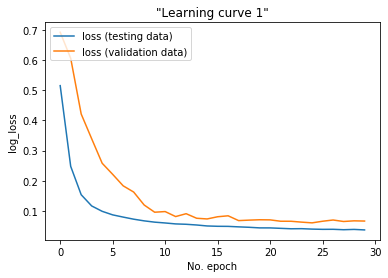

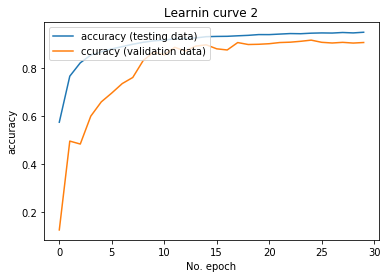

2/2 [==============================] - 1s 459ms/step - loss: 0.0665 - accuracy: 0.9054
Score for fold 1: loss of 0.06653551012277603; accuracy of 90.54223895072937%
2/2 [==============================] - 1s 451ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/30
18/18 [==============================] - 43s 2s/step - loss: 0.5769 - accuracy: 0.5458 - val_loss: 4.7057 - val_accuracy: 0.3488
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.2449 - accuracy: 0.7593 - val_loss: 0.5300 - val_accuracy: 0.7233
Epoch 3/30
18/18 [==============================] - 44s 2s/step - loss: 0.1558 - accuracy: 0.8148 - val_loss: 0.2886 - val_accuracy: 0.7255
Epoch 4/30
18/18 [==============================] - 44s 2s/step - loss: 0.1217 - accuracy: 0.8388 - val_loss: 0.2308 - val_accuracy: 0.7340
Epoch 5/30
18/18 [==============================] - 44s 2s/step - loss: 0.1042 - accuracy: 0.8594 - val_loss: 0.1798 - val_ac

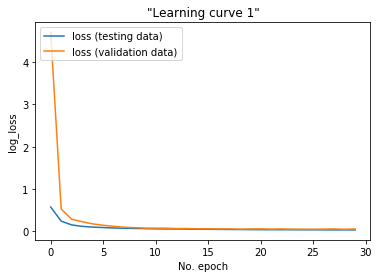

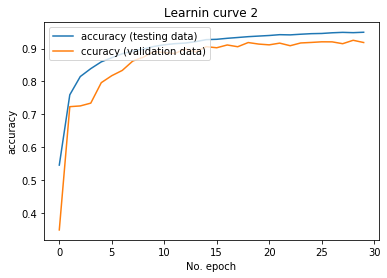

2/2 [==============================] - 1s 452ms/step - loss: 0.0598 - accuracy: 0.9182
Score for fold 2: loss of 0.05981362238526344; accuracy of 91.81787371635437%
2/2 [==============================] - 1s 458ms/step
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/30
18/18 [==============================] - 43s 2s/step - loss: 0.4705 - accuracy: 0.5833 - val_loss: 0.5564 - val_accuracy: 0.5895
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.1946 - accuracy: 0.7899 - val_loss: 0.4972 - val_accuracy: 0.6130
Epoch 3/30
18/18 [==============================] - 43s 2s/step - loss: 0.1385 - accuracy: 0.8158 - val_loss: 0.3271 - val_accuracy: 0.6637
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.1177 - accuracy: 0.8289 - val_loss: 0.2626 - val_accuracy: 0.6854
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.1056 - accuracy: 0.8363 - val_loss: 0.2096 - val_ac

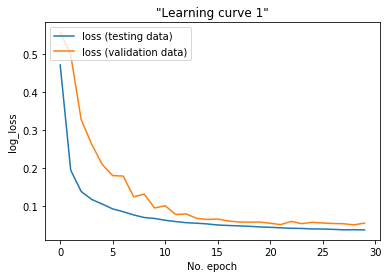

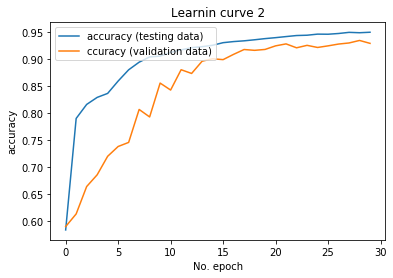

2/2 [==============================] - 1s 494ms/step - loss: 0.0556 - accuracy: 0.9290
Score for fold 3: loss of 0.05556875839829445; accuracy of 92.90060997009277%
2/2 [==============================] - 1s 460ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/30
18/18 [==============================] - 49s 3s/step - loss: 0.4762 - accuracy: 0.6086 - val_loss: 0.3927 - val_accuracy: 0.6665
Epoch 2/30
18/18 [==============================] - 48s 3s/step - loss: 0.1972 - accuracy: 0.8168 - val_loss: 0.3479 - val_accuracy: 0.7226
Epoch 3/30
18/18 [==============================] - 44s 2s/step - loss: 0.1259 - accuracy: 0.8519 - val_loss: 0.2937 - val_accuracy: 0.7423
Epoch 4/30
18/18 [==============================] - 44s 2s/step - loss: 0.1019 - accuracy: 0.8704 - val_loss: 0.2270 - val_accuracy: 0.7696
Epoch 5/30
18/18 [==============================] - 44s 2s/step - loss: 0.0900 - accuracy: 0.8812 - val_loss: 0.1720 - val_ac

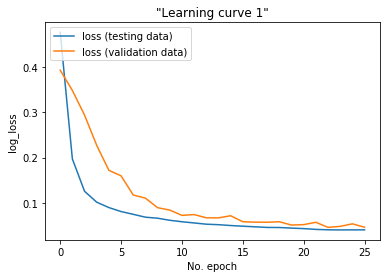

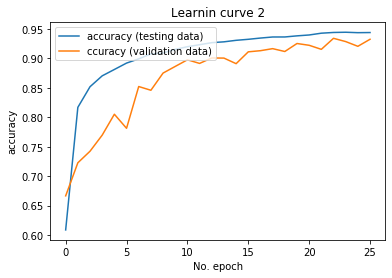

2/2 [==============================] - 1s 466ms/step - loss: 0.0468 - accuracy: 0.9325
Score for fold 4: loss of 0.046764057129621506; accuracy of 93.24970245361328%
2/2 [==============================] - 1s 436ms/step
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/30
18/18 [==============================] - 44s 2s/step - loss: 0.4387 - accuracy: 0.6625 - val_loss: 0.8871 - val_accuracy: 0.6624
Epoch 2/30
18/18 [==============================] - 44s 2s/step - loss: 0.1944 - accuracy: 0.8213 - val_loss: 0.3422 - val_accuracy: 0.6715
Epoch 3/30
18/18 [==============================] - 44s 2s/step - loss: 0.1159 - accuracy: 0.8622 - val_loss: 0.3232 - val_accuracy: 0.6892
Epoch 4/30
18/18 [==============================] - 44s 2s/step - loss: 0.0909 - accuracy: 0.8794 - val_loss: 0.2698 - val_accuracy: 0.7077
Epoch 5/30
18/18 [==============================] - 44s 2s/step - loss: 0.0795 - accuracy: 0.8912 - val_loss: 0.2320 - val_a

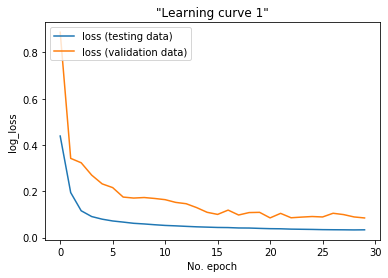

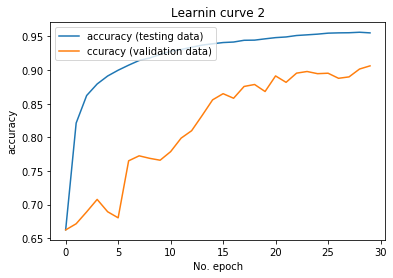

2/2 [==============================] - 1s 453ms/step - loss: 0.0848 - accuracy: 0.9063
Score for fold 5: loss of 0.08481210470199585; accuracy of 90.63277840614319%
2/2 [==============================] - 1s 449ms/step
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/30
18/18 [==============================] - 42s 2s/step - loss: 0.4082 - accuracy: 0.6772 - val_loss: 0.5561 - val_accuracy: 0.7263
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.1714 - accuracy: 0.8287 - val_loss: 0.2485 - val_accuracy: 0.7795
Epoch 3/30
18/18 [==============================] - 43s 2s/step - loss: 0.1182 - accuracy: 0.8537 - val_loss: 0.1761 - val_accuracy: 0.7730
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.0988 - accuracy: 0.8679 - val_loss: 0.1491 - val_accuracy: 0.8008
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.0881 - accuracy: 0.8782 - val_loss: 0.1196 - val_ac

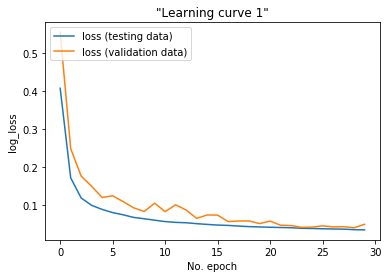

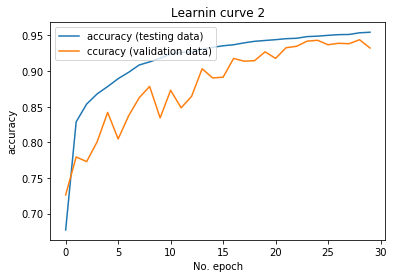

2/2 [==============================] - 1s 449ms/step - loss: 0.0488 - accuracy: 0.9323
Score for fold 6: loss of 0.04881102964282036; accuracy of 93.22605729103088%
2/2 [==============================] - 1s 456ms/step
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/30
18/18 [==============================] - 43s 2s/step - loss: 0.5685 - accuracy: 0.5037 - val_loss: 0.4195 - val_accuracy: 0.5789
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.2323 - accuracy: 0.8021 - val_loss: 0.2963 - val_accuracy: 0.6325
Epoch 3/30
18/18 [==============================] - 43s 2s/step - loss: 0.1415 - accuracy: 0.8230 - val_loss: 0.2619 - val_accuracy: 0.6719
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.1125 - accuracy: 0.8447 - val_loss: 0.2129 - val_accuracy: 0.7140
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.0988 - accuracy: 0.8604 - val_loss: 0.1724 - val_ac

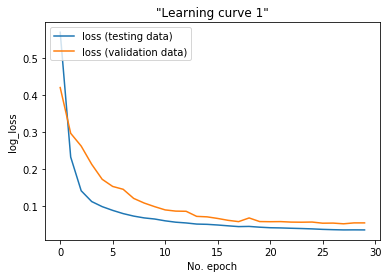

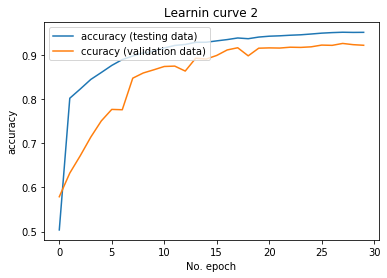

2/2 [==============================] - 1s 447ms/step - loss: 0.0550 - accuracy: 0.9221
Score for fold 7: loss of 0.05499832704663277; accuracy of 92.2123908996582%
2/2 [==============================] - 1s 444ms/step
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/30
18/18 [==============================] - 42s 2s/step - loss: 0.3904 - accuracy: 0.6111 - val_loss: 0.4065 - val_accuracy: 0.7245
Epoch 2/30
18/18 [==============================] - 42s 2s/step - loss: 0.1588 - accuracy: 0.7833 - val_loss: 0.3755 - val_accuracy: 0.5957
Epoch 3/30
18/18 [==============================] - 43s 2s/step - loss: 0.1160 - accuracy: 0.8415 - val_loss: 0.3141 - val_accuracy: 0.6726
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.0990 - accuracy: 0.8617 - val_loss: 0.2502 - val_accuracy: 0.7381
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.0882 - accuracy: 0.8746 - val_loss: 0.2306 - val_acc

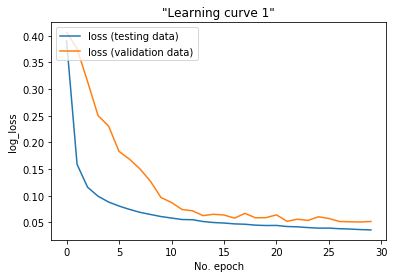

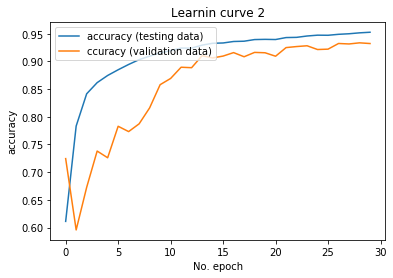

2/2 [==============================] - 1s 446ms/step - loss: 0.0517 - accuracy: 0.9323
Score for fold 8: loss of 0.051741600036621094; accuracy of 93.22792291641235%
2/2 [==============================] - 1s 443ms/step
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/30
18/18 [==============================] - 44s 2s/step - loss: 0.5592 - accuracy: 0.5965 - val_loss: 1.1513 - val_accuracy: 0.3544
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.2315 - accuracy: 0.7923 - val_loss: 0.2653 - val_accuracy: 0.7348
Epoch 3/30
18/18 [==============================] - 43s 2s/step - loss: 0.1345 - accuracy: 0.8347 - val_loss: 0.2593 - val_accuracy: 0.7116
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.1086 - accuracy: 0.8510 - val_loss: 0.2151 - val_accuracy: 0.7593
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.0974 - accuracy: 0.8632 - val_loss: 0.1915 - val_a

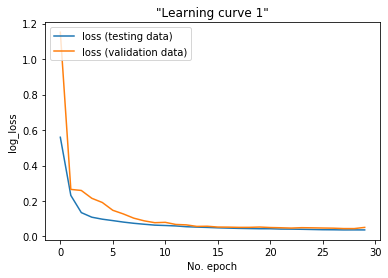

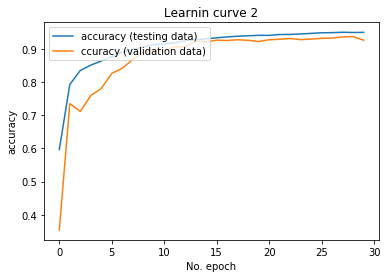

2/2 [==============================] - 1s 446ms/step - loss: 0.0510 - accuracy: 0.9259
Score for fold 9: loss of 0.05104362219572067; accuracy of 92.59290099143982%
2/2 [==============================] - 1s 438ms/step
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/30
18/18 [==============================] - 42s 2s/step - loss: 0.5259 - accuracy: 0.4636 - val_loss: 0.5640 - val_accuracy: 0.3711
Epoch 2/30
18/18 [==============================] - 42s 2s/step - loss: 0.2299 - accuracy: 0.7601 - val_loss: 0.5579 - val_accuracy: 0.5196
Epoch 3/30
18/18 [==============================] - 42s 2s/step - loss: 0.1449 - accuracy: 0.8140 - val_loss: 0.3040 - val_accuracy: 0.6716
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.1110 - accuracy: 0.8493 - val_loss: 0.2821 - val_accuracy: 0.6674
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.0927 - accuracy: 0.8734 - val_loss: 0.2263 - val_a

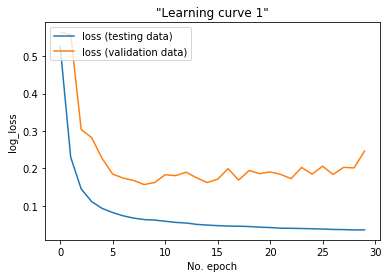

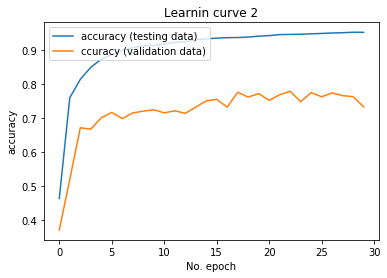

2/2 [==============================] - 1s 462ms/step - loss: 0.2462 - accuracy: 0.7330
Score for fold 10: loss of 0.2462102770805359; accuracy of 73.29936027526855%
2/2 [==============================] - 1s 484ms/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.06653551012277603 - Accuracy: 90.54223895072937%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.05981362238526344 - Accuracy: 91.81787371635437%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.05556875839829445 - Accuracy: 92.90060997009277%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.046764057129621506 - Accuracy: 93.24970245361328%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.08481210470199585 - Accuracy: 90.6327

In [43]:
from sklearn.model_selection import KFold
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []


# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    input_shape = Input((72,72,3))
    model = unet(input_shape)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    modelCallbacks = [EarlyStopping(monitor = 'loss', patience=2, verbose=1), ReduceLROnPlateau(monitor = 'loss', factor=0.2, patience=3 , min_lr=0.001, verbose=1)]
    # Fit data to model
    history = model.fit(inputs[train], targets[train], batch_size=31 , epochs=30, verbose=1, callbacks=modelCallbacks, validation_data=(inputs[test], targets[test]))
    
    # Plot history: loss
    plt.plot(history.history['loss'], label='loss (testing data)')
    plt.plot(history.history['val_loss'], label='loss (validation data)')
    plt.title('"Learning curve 1"')
    plt.ylabel('log_loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    # Plot history: accuracy
    plt.plot(history.history['accuracy'], label='accuracy (testing data)')
    plt.plot(history.history['val_accuracy'], label='ccuracy (validation data)')
    plt.title('Learnin curve 2')
    plt.ylabel('accuracy')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=1)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #save predictions
    preds = model.predict(inputs[test],verbose=1)
    preds = np.argmax(preds, axis=-1)
    mask_pred = create_3d_image(preds)
    preds2 = np.moveaxis(preds,0,-1)
    
    func_filename = os.path.join('/home/martin/Escritorio/red_neuronal_2/data/mask',path_sorted[fold_no-1])
    func = nib.load(func_filename)
    ni_img = nib.Nifti1Image(preds2, func.affine, func.header)
    nib.save(ni_img,os.path.join(paths_sorted[fold_no-1],'results.nii.gz'))
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [148]:
# cargamos los resultados
results_1 = np.array(load_mask_from_folder('/home/martin/Escritorio/red_neuronal_2/results'))

In [151]:
# cargamos las mascaras predichas y aislamos los tejidos
paciente = results_1[0]
paciente2 = tf.keras.utils.to_categorical(paciente)
for i in range(7):
    mask = paciente2[:,:,:,i]
    func_filename = os.path.join('/home/martin/Escritorio/PACIENTES_2/042919_1','042919_1_gm.nii')
    func = nib.load(func_filename)
    ni_img = nib.Nifti1Image(mask, func.affine, func.header)
    nib.save(ni_img,os.path.join(paths_sorted[i],'results.nii.gz'))
        
        

In [169]:
# cargamos las imagenes de entrada, salida y mascaras
inputs = np.array(slice_3d_image(made_three_channel_image(load_images_from_folder('/home/martin/Escritorio/red_neuronal_2/data/images'))))
targets = np.array(slice_3d_image(load_mask_from_folder('/home/martin/Escritorio/red_neuronal_2/data/mask')))
predics = np.array(slice_3d_image(load_mask_from_folder('/home/martin/Escritorio/red_neuronal_2/results')))

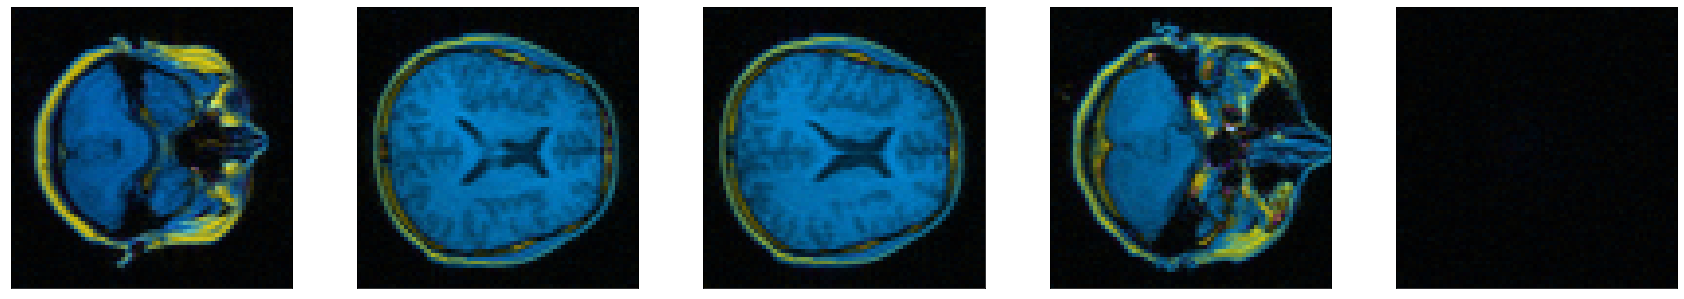

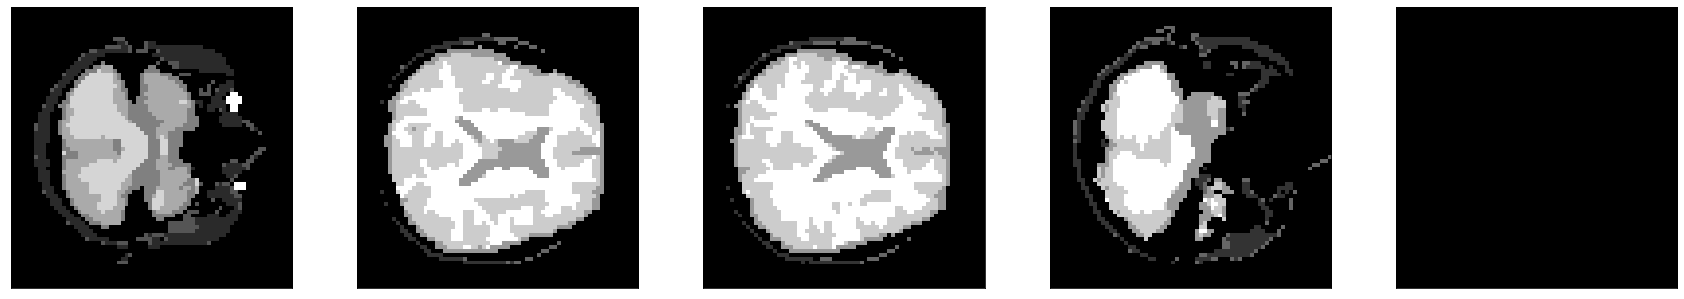

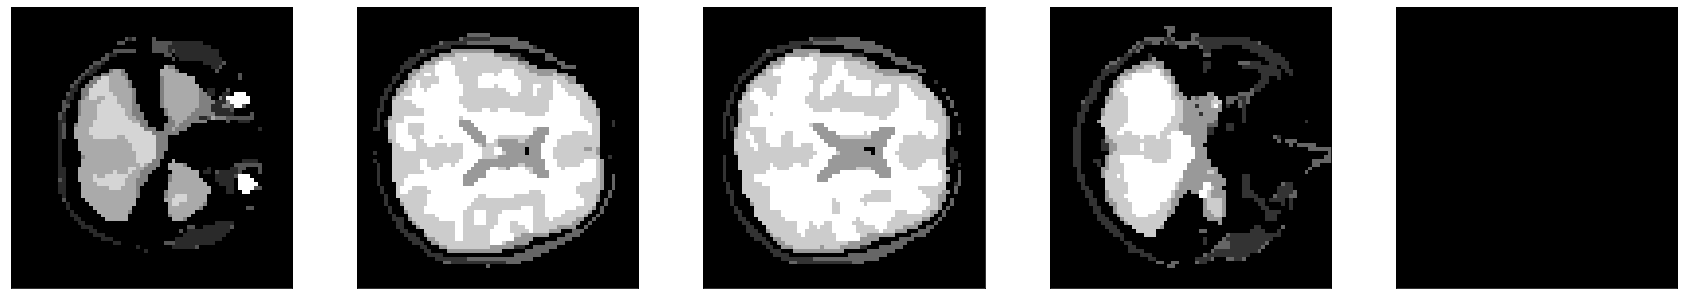

In [171]:
#representamos imagenes de entrada, salida y mascaras respectiva
plt.figure(figsize=(30,30))
random_inds = np.random.choice(216,5) #busco de la 216, 5 imagenes al azar
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(inputs[image_ind]), cmap='gray')
    
plt.figure(figsize=(30,30))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]    
    plt.imshow(targets[image_ind], cmap='gray')

plt.figure(figsize=(30,30))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]    
    plt.imshow(predics[image_ind], cmap='gray')

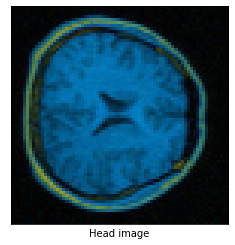

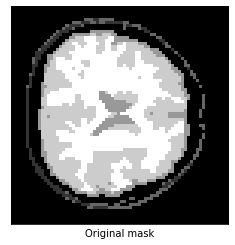

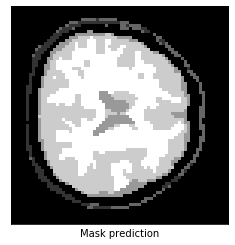

In [108]:
# hacemos plot de alguna solucion
plot_sample(imputs,targets,predics, ix= 30)